https://dacon.io/competitions/official/235848/codeshare/4046?page=1&dtype=recent<br>
Random Forest, Extra Tree Classifier, LGBM을 StackingClassifier로 스태킹한 모델. <br>
Hyperparamter은 Optuna을 활용하여 조정.<br>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest

In [6]:
# setting seed (reproductibility)

seed = 2021

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [7]:
train = pd.read_csv('./_data/train.csv')
test = pd.read_csv('./_data/test.csv')
submission = pd.read_csv('./_data/sample_submission.csv')

In [8]:
train

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,1,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
1,2,52,1,3,152,298,1,1,178,0,1.2,1,0,3,1
2,3,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
3,4,45,0,0,138,236,0,0,152,1,0.2,1,0,2,1
4,5,35,1,1,122,192,0,1,174,0,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147,50,1,2,140,233,0,1,163,0,0.6,1,1,3,0
147,148,51,1,2,94,227,0,1,154,1,0.0,2,1,3,1
148,149,69,1,3,160,234,1,0,131,0,0.1,1,1,2,1
149,150,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0


In [9]:
test

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,1,57,1,0,150,276,0,0,112,1,0.6,1,1,1
1,2,59,1,3,170,288,0,0,159,0,0.2,1,0,3
2,3,57,1,2,150,126,1,1,173,0,0.2,2,1,3
3,4,56,0,0,134,409,0,0,150,1,1.9,1,2,3
4,5,71,0,2,110,265,1,0,130,0,0.0,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,148,64,0,0,130,303,0,1,122,0,2.0,1,2,2
148,149,43,0,0,132,341,1,0,136,1,3.0,1,0,3
149,150,53,1,0,123,282,0,1,95,1,2.0,1,2,3
150,151,67,0,2,152,277,0,1,172,0,0.0,2,1,2


In [36]:
# 변수 특징 파악
from dataprep.eda import create_report
report = create_report(train)

  0%|                                                                                         | 0/1873 [00:00<…

In [37]:
report.save('dataprep_reoprt')

Report has been saved to dataprep_reoprt.html!


<AxesSubplot:title={'center':'Correlation of Features'}>

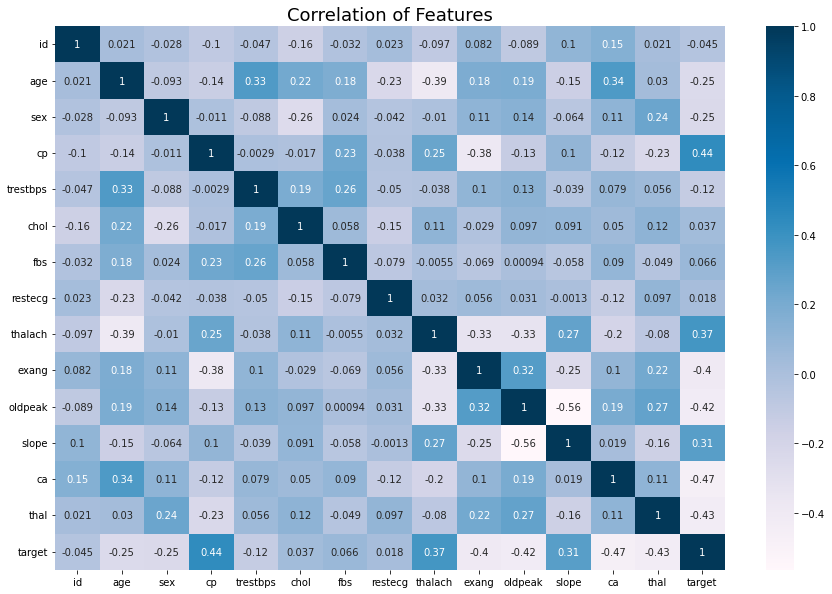

In [11]:
#correlation

plt.figure(figsize = (15,10))
plt.title('Correlation of Features',size=18)

sns.heatmap(train.corr(), cmap = plt.cm.PuBu, linecolor = 'white',annot =True)

In [12]:
#Checking for multicollinearity
model = ols('target ~ age + sex + cp + trestbps + chol + fbs + restecg + thalach + exang + oldpeak + slope + ca + thal', train)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     13.87
Date:                Tue, 28 Dec 2021   Prob (F-statistic):           2.74e-19
Time:                        16:41:57   Log-Likelihood:                -45.434
No. Observations:                 151   AIC:                             118.9
Df Residuals:                     137   BIC:                             161.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7935      0.392      2.026      0.045       0.019       1.568
age            0.0008      0.004      0.188      0.851      -0.007       0.009
sex           -0.1158      0.067     -1.725      0.087      -0.249       0.017
cp             0.1128      0.030      3.703      0.000       0.053       0.173
trestbps      -0.0024      0.002     -1.379      0.170      -0.006       0.001
chol           0.0005      0.001      0.814      0.417      -0.001       0.002
fbs            0.0737      0.083      0.886      0.377      -0.091       0.238
restecg        0.0178      0.058      0.309      0.758      -0.096       0.132
thalach        0.0023      0.001      1.595      0.113      -0.001       0.005
exang         -0.1001      0.070     -1.433      0.154      -0.238       0.038
oldpeak       -0.0456      0.035     -1.296      0.197      -0.115       0.024
slope          0.1036      0.056      1.850      0.067      -0.007       0.214
ca            -0.1928      0.034     -5.658      0.000      -0.260      -0.125
thal          -0.1917      0.052     -3.687      0.000      -0.295      -0.089
==============================================================================
Omnibus:                        1.735   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                1.713
Skew:                          -0.255   Prob(JB):                        0.425
Kurtosis:                       2.886   Cond. No.                     4.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* The condition number is large, 4.56e+03. This might indicate that there are strong multicollinearity or other numerical problems. <br>
* 다중공선성 주의?

In [13]:
pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept') 

,컬럼,VIF
0,age,1.655602
1,sex,1.252537
2,cp,1.318144
3,trestbps,1.243198
4,chol,1.337083
5,fbs,1.186257
6,restecg,1.119901
7,thalach,1.491819
8,exang,1.371635
9,oldpeak,1.860286


```variance_inflation_factor``` 를 이용해서 VIF 구함. 5이상 주의 10이상이면 drop..이라고 하는데...hmm

In [38]:
df = pd.DataFrame({'컬럼': column, 'VIF': variance_inflation_factor(model.exog, i)} 
             for i, column in enumerate(model.exog_names)
             if column != 'Intercept') 


In [40]:
df.sort_values(by=['VIF'],ascending=False)

,컬럼,VIF
9,oldpeak,1.860286
0,age,1.655602
10,slope,1.637963
7,thalach,1.491819
8,exang,1.371635
4,chol,1.337083
2,cp,1.318144
12,thal,1.256305
1,sex,1.252537
11,ca,1.244163


변수와의 상관관계를 파악했을 때 ca, cp, oldpeak, sex, exang, slope만 사용하기로 결정. 범주형 변수들은 더미변수로 변환.
?.?..

In [15]:
#merging train set & test set
train_x = train.drop(["id", "target"], axis = 1)
train_y = train.iloc[:, train.columns == "target"]
test_x = test.iloc[:, test.columns!='id']
data_combined = pd.concat([train_x, test_x], ignore_index = True)

In [16]:
#selecting variables

data_combined = data_combined[['ca', 'cp', 'oldpeak', 'sex', 'exang', 'slope']]

In [17]:
data_combined = pd.get_dummies(data = data_combined, columns = ['slope'], prefix = 'slope')
data_combined = pd.get_dummies(data = data_combined, columns = ['cp'], prefix = 'cp')
data_combined = pd.get_dummies(data = data_combined, columns = ['ca'], prefix = 'ca')

In [18]:
data_combined

,oldpeak,sex,exang,slope_0,slope_1,slope_2,cp_0,cp_1,cp_2,cp_3,ca_0,ca_1,ca_2,ca_3,ca_4
0,1.2,1,0,1,0,0,0,0,1,0,1,0,0,0,0
1,1.2,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,0.0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
3,0.2,0,1,0,1,0,1,0,0,0,1,0,0,0,0
4,0.0,1,0,0,0,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,2.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
299,3.0,0,1,0,1,0,1,0,0,0,1,0,0,0,0
300,2.0,1,1,0,1,0,1,0,0,0,0,0,1,0,0
301,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0,0


In [19]:
#splitting the dataset again into train and test set

train_x = data_combined[: train.shape[0]]
new_test = data_combined[train.shape[0]:]

In [20]:
train_x

,oldpeak,sex,exang,slope_0,slope_1,slope_2,cp_0,cp_1,cp_2,cp_3,ca_0,ca_1,ca_2,ca_3,ca_4
0,1.2,1,0,1,0,0,0,0,1,0,1,0,0,0,0
1,1.2,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,0.0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
3,0.2,0,1,0,1,0,1,0,0,0,1,0,0,0,0
4,0.0,1,0,0,0,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,0.6,1,0,0,1,0,0,0,1,0,0,1,0,0,0
147,0.0,1,1,0,0,1,0,0,1,0,0,1,0,0,0
148,0.1,1,0,0,1,0,0,0,0,1,0,1,0,0,0
149,0.8,1,0,0,0,1,1,0,0,0,1,0,0,0,0


In [21]:
new_test

,oldpeak,sex,exang,slope_0,slope_1,slope_2,cp_0,cp_1,cp_2,cp_3,ca_0,ca_1,ca_2,ca_3,ca_4
151,0.6,1,1,0,1,0,1,0,0,0,0,1,0,0,0
152,0.2,1,0,0,1,0,0,0,0,1,1,0,0,0,0
153,0.2,1,0,0,0,1,0,0,1,0,0,1,0,0,0
154,1.9,0,1,0,1,0,1,0,0,0,0,0,1,0,0
155,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,2.0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
299,3.0,0,1,0,1,0,1,0,0,0,1,0,0,0,0
300,2.0,1,1,0,1,0,1,0,0,0,0,0,1,0,0
301,0.0,0,0,0,0,1,0,0,1,0,0,1,0,0,0


In [24]:
import sklearn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import optuna
from optuna.samplers import TPESampler
import joblib
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [25]:
#changing target into array
train_y  = train_y.to_numpy()

In [26]:
# random forest classifier
def objective_ET(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 5,100, step = 5),
        "max_depth": trial.suggest_int("max_depth", 1,20),
        "min_samples_split": trial.suggest_int("min_samples_split",2,10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf",1,5),
        "random_state": trial.suggest_categorical("random_state", [2021])
    }
    model = RandomForestClassifier(**param)

    kfold = StratifiedKFold(n_splits = 5)
    cc = sklearn.model_selection.cross_val_score(model, train_x, train_y, n_jobs=-1, cv=5).mean()

    return cc

In [27]:
sampler = TPESampler(seed=seed)
study = optuna.create_study(
        study_name="ET_optimizer",
        direction= "maximize",
        sampler=sampler,
    )

study.optimize(objective_ET, n_trials= 1000)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

print(study.best_trial.params)

[I 2021-12-28 16:44:51,798] A new study created in memory with name: ET_optimizer
[I 2021-12-28 16:44:58,633] Trial 0 finished with value: 0.8010752688172044 and parameters: {'n_estimators': 65, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'random_state': 2021}. Best is trial 0 with value: 0.8010752688172044.
[I 2021-12-28 16:45:01,953] Trial 1 finished with value: 0.7948387096774194 and parameters: {'n_estimators': 100, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 0 with value: 0.8010752688172044.
[I 2021-12-28 16:45:02,321] Trial 2 finished with value: 0.7877419354838711 and parameters: {'n_estimators': 70, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 0 with value: 0.8010752688172044.
[I 2021-12-28 16:45:02,786] Trial 3 finished with value: 0.7946236559139785 and parameters: {'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf':

[I 2021-12-28 16:45:10,370] Trial 31 finished with value: 0.8212903225806452 and parameters: {'n_estimators': 35, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:10,602] Trial 32 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:10,870] Trial 33 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 20, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:11,209] Trial 34 finished with value: 0.8079569892473119 and parameters: {'n_estimators': 40, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2

[I 2021-12-28 16:45:19,922] Trial 63 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 30, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:20,100] Trial 64 finished with value: 0.7946236559139785 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:20,411] Trial 65 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 40, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:20,679] Trial 66 finished with value: 0.8079569892473119 and parameters: {'n_estimators': 35, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 202

[I 2021-12-28 16:45:27,808] Trial 95 finished with value: 0.8208602150537635 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:28,007] Trial 96 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 40, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:28,173] Trial 97 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2021-12-28 16:45:28,390] Trial 98 finished with value: 0.8212903225806452 and parameters: {'n_estimators': 35, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 19 with value: 0.827741935483871.
[I 2

[I 2021-12-28 16:45:34,578] Trial 127 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:34,764] Trial 128 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:34,962] Trial 129 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:35,098] Trial 130 finished with value: 0.8010752688172044 and parameters: {'n_estimators': 15, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:45:40,827] Trial 158 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:41,053] Trial 159 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:41,311] Trial 160 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:41,541] Trial 161 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946

[I 2021-12-28 16:45:47,297] Trial 189 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:47,554] Trial 190 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:47,789] Trial 191 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:47,998] Trial 192 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946

[I 2021-12-28 16:45:53,733] Trial 220 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:53,965] Trial 221 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:54,107] Trial 222 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:45:54,273] Trial 223 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:46:00,817] Trial 251 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:01,095] Trial 252 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:01,386] Trial 253 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:01,631] Trial 254 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:46:07,610] Trial 282 finished with value: 0.7946236559139785 and parameters: {'n_estimators': 70, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:07,762] Trial 283 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:08,026] Trial 284 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:08,224] Trial 285 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:46:15,566] Trial 313 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:15,862] Trial 314 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:16,048] Trial 315 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:16,226] Trial 316 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:46:21,782] Trial 344 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:21,989] Trial 345 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:22,144] Trial 346 finished with value: 0.8010752688172044 and parameters: {'n_estimators': 15, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:22,612] Trial 347 finished with value: 0.787956989247312 and parameters: {'n_estimators': 80, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:46:28,079] Trial 375 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:28,252] Trial 376 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:28,437] Trial 377 finished with value: 0.7746236559139785 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:28,607] Trial 378 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:46:33,809] Trial 406 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 35, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:33,991] Trial 407 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:34,157] Trial 408 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:34,331] Trial 409 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:46:39,701] Trial 437 finished with value: 0.8075268817204302 and parameters: {'n_estimators': 25, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:39,876] Trial 438 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:40,092] Trial 439 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:40,267] Trial 440 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:46:45,602] Trial 468 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:45,783] Trial 469 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:45,935] Trial 470 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:46,113] Trial 471 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:46:51,248] Trial 499 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:51,415] Trial 500 finished with value: 0.8273118279569893 and parameters: {'n_estimators': 25, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:51,601] Trial 501 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:51,783] Trial 502 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:46:56,833] Trial 530 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:57,027] Trial 531 finished with value: 0.7946236559139785 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:57,188] Trial 532 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:46:57,369] Trial 533 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:47:02,823] Trial 561 finished with value: 0.787956989247312 and parameters: {'n_estimators': 75, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:03,013] Trial 562 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:03,195] Trial 563 finished with value: 0.7946236559139785 and parameters: {'n_estimators': 25, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:03,358] Trial 564 finished with value: 0.80752688172043 and parameters: {'n_estimators': 20, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:47:08,998] Trial 592 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:09,188] Trial 593 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:09,366] Trial 594 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:09,530] Trial 595 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:47:15,074] Trial 623 finished with value: 0.8077419354838711 and parameters: {'n_estimators': 20, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:15,256] Trial 624 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:15,440] Trial 625 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:15,608] Trial 626 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:47:20,964] Trial 654 finished with value: 0.8077419354838711 and parameters: {'n_estimators': 20, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:21,230] Trial 655 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:21,500] Trial 656 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 35, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:21,738] Trial 657 finished with value: 0.8208602150537635 and parameters: {'n_estimators': 25, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:47:28,064] Trial 685 finished with value: 0.8008602150537636 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:28,248] Trial 686 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:28,426] Trial 687 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:28,587] Trial 688 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:47:35,228] Trial 716 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:35,393] Trial 717 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:35,589] Trial 718 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:35,747] Trial 719 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236

[I 2021-12-28 16:47:42,417] Trial 747 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:42,661] Trial 748 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:42,949] Trial 749 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:43,230] Trial 750 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462

[I 2021-12-28 16:47:50,754] Trial 778 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:50,942] Trial 779 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:51,143] Trial 780 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 25, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:51,357] Trial 781 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236

[I 2021-12-28 16:47:56,721] Trial 809 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:56,900] Trial 810 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:57,097] Trial 811 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:47:57,277] Trial 812 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:48:03,483] Trial 840 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:03,681] Trial 841 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:03,860] Trial 842 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:04,167] Trial 843 finished with value: 0.7946236559139785 and parameters: {'n_estimators': 65, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946

[I 2021-12-28 16:48:10,115] Trial 871 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:10,320] Trial 872 finished with value: 0.8273118279569893 and parameters: {'n_estimators': 25, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:10,522] Trial 873 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:10,717] Trial 874 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

[I 2021-12-28 16:48:16,379] Trial 902 finished with value: 0.7946236559139785 and parameters: {'n_estimators': 15, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:16,533] Trial 903 finished with value: 0.7810752688172042 and parameters: {'n_estimators': 10, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:16,747] Trial 904 finished with value: 0.827741935483871 and parameters: {'n_estimators': 30, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:16,922] Trial 905 finished with value: 0.8077419354838711 and parameters: {'n_estimators': 20, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 105 with value: 0.83397849462365

[I 2021-12-28 16:48:22,545] Trial 933 finished with value: 0.7812903225806451 and parameters: {'n_estimators': 20, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:22,744] Trial 934 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:22,940] Trial 935 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:23,118] Trial 936 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236

[I 2021-12-28 16:48:28,931] Trial 964 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:29,406] Trial 965 finished with value: 0.787956989247312 and parameters: {'n_estimators': 100, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:29,608] Trial 966 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:29,812] Trial 967 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946

[I 2021-12-28 16:48:35,423] Trial 995 finished with value: 0.813978494623656 and parameters: {'n_estimators': 20, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:35,638] Trial 996 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 30, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:35,836] Trial 997 finished with value: 0.8339784946236559 and parameters: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.8339784946236559.
[I 2021-12-28 16:48:36,045] Trial 998 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 35, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 105 with value: 0.833978494623

Best Score: 0.8339784946236559
Best trial: {'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}
{'n_estimators': 25, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'random_state': 2021}


In [28]:
#extra tree classifier
def objective_ET1(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10,200, step = 5),
        "criterion": trial.suggest_categorical("criterion", ['gini','entropy']),
        "max_depth": trial.suggest_int("max_depth", 2,20),
        "min_samples_split": trial.suggest_int("min_samples_split",2,10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf",1,5),
        "random_state": trial.suggest_categorical("random_state", [2021])
    }
    model = ExtraTreesClassifier(**param)

    kfold = StratifiedKFold(n_splits = 5)
    cc = sklearn.model_selection.cross_val_score(model, train_x, train_y, n_jobs=-1, cv=5).mean()

    return cc

In [29]:
sampler = TPESampler(seed=seed)
study = optuna.create_study(
        study_name="ET_optimizer",
        direction= "maximize",
        sampler=sampler,
    )

study.optimize(objective_ET1, n_trials= 1000)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

print(study.best_trial.params)

[I 2021-12-28 16:56:51,989] A new study created in memory with name: ET_optimizer
[I 2021-12-28 16:56:56,405] Trial 0 finished with value: 0.8079569892473119 and parameters: {'n_estimators': 125, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 0 with value: 0.8079569892473119.
[I 2021-12-28 16:56:59,204] Trial 1 finished with value: 0.7746236559139785 and parameters: {'n_estimators': 40, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 0 with value: 0.8079569892473119.
[I 2021-12-28 16:56:59,941] Trial 2 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 195, 'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 2 with value: 0.8210752688172043.
[I 2021-12-28 16:57:00,388] Trial 3 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 

[I 2021-12-28 16:57:14,809] Trial 29 finished with value: 0.7617204301075269 and parameters: {'n_estimators': 135, 'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1, 'random_state': 2021}. Best is trial 10 with value: 0.827741935483871.
[I 2021-12-28 16:57:15,405] Trial 30 finished with value: 0.827741935483871 and parameters: {'n_estimators': 165, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 2, 'random_state': 2021}. Best is trial 10 with value: 0.827741935483871.
[I 2021-12-28 16:57:16,010] Trial 31 finished with value: 0.827741935483871 and parameters: {'n_estimators': 165, 'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 2, 'random_state': 2021}. Best is trial 10 with value: 0.827741935483871.
[I 2021-12-28 16:57:16,573] Trial 32 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 165, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10, 

[I 2021-12-28 16:57:24,636] Trial 58 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 50 with value: 0.8410752688172043.
[I 2021-12-28 16:57:24,758] Trial 59 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:24,891] Trial 60 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:25,051] Trial 61 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 35, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf'

[I 2021-12-28 16:57:28,758] Trial 88 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:28,929] Trial 89 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:29,062] Trial 90 finished with value: 0.8141935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:29,190] Trial 91 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5

[I 2021-12-28 16:57:33,352] Trial 118 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 115, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:33,572] Trial 119 finished with value: 0.8408602150537634 and parameters: {'n_estimators': 35, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:33,755] Trial 120 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 30, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:33,875] Trial 121 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_lea

[I 2021-12-28 16:57:37,484] Trial 148 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:37,637] Trial 149 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 30, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:37,777] Trial 150 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 59 with value: 0.84752688172043.
[I 2021-12-28 16:57:37,901] Trial 151 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf':

[I 2021-12-28 16:57:41,128] Trial 177 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:41,242] Trial 178 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:41,373] Trial 179 finished with value: 0.7883870967741935 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:41,507] Trial 180 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3, 'min_sam

[I 2021-12-28 16:57:44,691] Trial 206 finished with value: 0.8408602150537634 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:44,797] Trial 207 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:44,910] Trial 208 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:45,019] Trial 209 finished with value: 0.8346236559139785 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_sa

[I 2021-12-28 16:57:48,403] Trial 235 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:48,536] Trial 236 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:48,656] Trial 237 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:48,793] Trial 238 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_sampl

[I 2021-12-28 16:57:52,384] Trial 264 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:52,508] Trial 265 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:52,637] Trial 266 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:52,763] Trial 267 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_sam

[I 2021-12-28 16:57:56,789] Trial 293 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:56,921] Trial 294 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:57,026] Trial 295 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:57:57,144] Trial 296 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_sampl

[I 2021-12-28 16:58:02,109] Trial 322 finished with value: 0.7883870967741935 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:02,271] Trial 323 finished with value: 0.8212903225806452 and parameters: {'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:02,531] Trial 324 finished with value: 0.8146236559139786 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:02,772] Trial 325 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_

[I 2021-12-28 16:58:08,015] Trial 351 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:08,203] Trial 352 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:08,368] Trial 353 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:08,520] Trial 354 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_sam

[I 2021-12-28 16:58:14,803] Trial 380 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 160, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:15,021] Trial 381 finished with value: 0.8412903225806453 and parameters: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:15,249] Trial 382 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:15,385] Trial 383 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min

[I 2021-12-28 16:58:21,268] Trial 409 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 145, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:21,453] Trial 410 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:21,688] Trial 411 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 30, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:21,938] Trial 412 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samp

[I 2021-12-28 16:58:27,496] Trial 438 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:27,628] Trial 439 finished with value: 0.8412903225806453 and parameters: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:27,758] Trial 440 finished with value: 0.8408602150537634 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:27,976] Trial 441 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min

[I 2021-12-28 16:58:33,288] Trial 467 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:33,404] Trial 468 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:33,560] Trial 469 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:33,702] Trial 470 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3, 'min_sampl

[I 2021-12-28 16:58:37,445] Trial 496 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:37,596] Trial 497 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:37,771] Trial 498 finished with value: 0.827741935483871 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:37,909] Trial 499 finished with value: 0.8412903225806451 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_s

[I 2021-12-28 16:58:42,260] Trial 525 finished with value: 0.8017204301075269 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:42,379] Trial 526 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:42,515] Trial 527 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:42,647] Trial 528 finished with value: 0.8341935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_sa

[I 2021-12-28 16:58:46,363] Trial 554 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:46,490] Trial 555 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:47,071] Trial 556 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 180, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:47,642] Trial 557 finished with value: 0.821505376344086 and parameters: {'n_estimators': 170, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, '

[I 2021-12-28 16:58:52,017] Trial 583 finished with value: 0.8275268817204301 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:52,168] Trial 584 finished with value: 0.8475268817204302 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:52,293] Trial 585 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:52,438] Trial 586 finished with value: 0.8410752688172044 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_sam

[I 2021-12-28 16:58:56,683] Trial 612 finished with value: 0.821505376344086 and parameters: {'n_estimators': 35, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:56,800] Trial 613 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:57,307] Trial 614 finished with value: 0.821505376344086 and parameters: {'n_estimators': 150, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:58:57,477] Trial 615 finished with value: 0.8412903225806451 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_s

[I 2021-12-28 16:59:01,611] Trial 641 finished with value: 0.84752688172043 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:01,757] Trial 642 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:01,885] Trial 643 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:02,070] Trial 644 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 30, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, '

[I 2021-12-28 16:59:06,601] Trial 670 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:06,736] Trial 671 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:06,897] Trial 672 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:07,079] Trial 673 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 30, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 4, 'min

[I 2021-12-28 16:59:12,112] Trial 699 finished with value: 0.8412903225806451 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:12,285] Trial 700 finished with value: 0.8408602150537634 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:12,512] Trial 701 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 35, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:12,694] Trial 702 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min

[I 2021-12-28 16:59:18,030] Trial 728 finished with value: 0.821505376344086 and parameters: {'n_estimators': 60, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:18,181] Trial 729 finished with value: 0.8210752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:18,304] Trial 730 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:18,454] Trial 731 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'min_s

[I 2021-12-28 16:59:23,092] Trial 757 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:23,224] Trial 758 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:23,384] Trial 759 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:23,575] Trial 760 finished with value: 0.8408602150537636 and parameters: {'n_estimators': 25, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 6, 'min

[I 2021-12-28 16:59:28,033] Trial 786 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:28,192] Trial 787 finished with value: 0.8412903225806451 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:28,359] Trial 788 finished with value: 0.84752688172043 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:28,499] Trial 789 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 8, 'min_sa

[I 2021-12-28 16:59:32,839] Trial 815 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:33,090] Trial 816 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 50, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:33,239] Trial 817 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:33,410] Trial 818 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 7, 'min_sam

[I 2021-12-28 16:59:39,091] Trial 844 finished with value: 0.827741935483871 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:39,230] Trial 845 finished with value: 0.827741935483871 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:39,439] Trial 846 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:39,591] Trial 847 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samp

[I 2021-12-28 16:59:44,886] Trial 873 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:45,028] Trial 874 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:45,233] Trial 875 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:45,391] Trial 876 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_

[I 2021-12-28 16:59:50,329] Trial 902 finished with value: 0.8344086021505376 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:50,487] Trial 903 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:50,638] Trial 904 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:50,808] Trial 905 finished with value: 0.8281720430107526 and parameters: {'n_estimators': 20, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_

[I 2021-12-28 16:59:55,945] Trial 931 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:56,111] Trial 932 finished with value: 0.8475268817204302 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:56,261] Trial 933 finished with value: 0.8148387096774193 and parameters: {'n_estimators': 20, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 16:59:56,404] Trial 934 finished with value: 0.80752688172043 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 5, 'min_sa

[I 2021-12-28 17:00:02,812] Trial 960 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 17:00:02,984] Trial 961 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 17:00:03,147] Trial 962 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 17:00:03,342] Trial 963 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'min_

[I 2021-12-28 17:00:09,037] Trial 989 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 17:00:09,246] Trial 990 finished with value: 0.8410752688172043 and parameters: {'n_estimators': 25, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 17:00:09,419] Trial 991 finished with value: 0.8541935483870968 and parameters: {'n_estimators': 15, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 5, 'random_state': 2021}. Best is trial 155 with value: 0.8541935483870968.
[I 2021-12-28 17:00:09,566] Trial 992 finished with value: 0.8083870967741935 and parameters: {'n_estimators': 10, 'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 4, 'min_

Best Score: 0.8541935483870968
Best trial: {'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}
{'n_estimators': 15, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 5, 'random_state': 2021}


In [30]:
from sklearn.ensemble import StackingClassifier

estimators = [
              ('rf', RandomForestClassifier(n_estimators = 25, max_depth = 10, min_samples_split = 8, min_samples_leaf = 4, random_state=2021)),
              ('tree', ExtraTreesClassifier(n_estimators = 15, criterion = 'gini', max_depth = 3, min_samples_split=4, min_samples_leaf= 5, random_state = 2021)),
              ('lgbm', LGBMClassifier(n_estimators = 8, max_depth = 15, min_samples_split = 10, min_samples_leaf = 2, learning_rate = 0.44617753240161157, random_state = 2021))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv = 5)
clf.fit(train_x, train_y.ravel())

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Curr

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=4,
                                                       min_samples_split=8,
                                                       n_estimators=25,
                                                       random_state=2021)),
                               ('tree',
                                ExtraTreesClassifier(max_depth=3,
                                                     min_samples_leaf=5,
                                                     min_samples_split=4,
                                                     n_estimators=15,
                                                     random_state=2021)),
                               ('lgbm',
                                LGBMClassifier(learning_rate=0.44617753240161157,
                                               max

In [31]:
prediction = clf.predict(new_test)


In [33]:
submission['target'] = prediction
submission

,id,target
0,1,0
1,2,1
2,3,1
3,4,0
4,5,1
...,...,...
147,148,0
148,149,0
149,150,0
150,151,1


In [34]:
submission.to_csv("submission_private8.csv", index=False)